### Trying different classifiers on data of KdV patients and ID controls
Overview of this notebook:

First the deepface representations of the cropped images are read in from an Excel file. The data is then plotted by using either t-sne or PCA for dimension reduction. It is clear that there aren't two clear clusters.

In the rest of the notebook the following classifiers are tested: k-NN, SVM, Random Forest, Gradient Boosting, AdaBoost, Gaussian Naive Bayes. In the end also an ensemble of all these methods or some of them is tried. None outperforming the Gradient Boosting classifier. 

To normalize the data either Normalizer (unit form) or StandardScaler (z = (x - mean)/std) is used, without any specific difference in performance yet.  

In [29]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import itertools
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
import seaborn as sns

In [30]:
def read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir):
    
    # open directories
    kdv_dir = data_dir+"\\kdv-patients-age-group-"+str(low_age) + "-" + str(high_age)
    ID_dir = data_dir+ "\\kdv-selected-ID-controls-age-group-"+str(low_age) + "-" + str(high_age)

    # get list of filenames
    files_kdv = [f for f in listdir(kdv_dir) if (isfile(join(kdv_dir, f)) & ("crop_sized.jpg" in f))]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ("crop_sized.JPG" in f))]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, kdv_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_kdv or row[0] in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(rep)
                    labels.append(i)
    
    return np.array(data), np.array(labels)

In [31]:
def read_rep2(kdv_csv, ID_csv, low_age, high_age, data_dir):
    
    # open directories
    kdv_dir = data_dir+"\\kdv-patients-age-group-"+str(low_age) + "-" + str(high_age)
    ID_dir = data_dir+ "\\kdv-selected-ID-controls-age-group-"+str(low_age) + "-" + str(high_age)

    # get list of filenames
    files_kdv = [f for f in listdir(kdv_dir) if (isfile(join(kdv_dir, f)) & ("crop_sized.jpg" in f))]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ("crop_sized.JPG" in f))]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, kdv_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_kdv or row[0] in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(row)
                    labels.append(i)
    
    return np.array(data), np.array(labels)

In [32]:
def plot_pca_tsne(data, labels, lowest_age = -1, highest_age = -1):
    plt.figure(figsize=(12,6))
    plt.plot([1,2])

    # visualize data in tnse (men/women)
    X_embedded_tsne = TSNE(n_components=2, init='pca').fit_transform(data)

    plt.subplot(121)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_tsne[j, 0] for j  in range(len(X_embedded_tsne[:,0])) if labels[j] == u]
        yi = [X_embedded_tsne[j, 1] for j  in range(len(X_embedded_tsne[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("t-sne for age range {}-{}".format(lowest_age, highest_age))

    # visualize data in pca (men/women)
    X_embedded_pca = PCA(n_components=2).fit_transform(data)

    plt.subplot(122)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_pca[j, 0] for j  in range(len(X_embedded_pca[:,0])) if labels[j] == u]
        yi = [X_embedded_pca[j, 1] for j  in range(len(X_embedded_pca[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("pca for age range{}-{}".format(lowest_age, highest_age))

    plt.show()

In [33]:
def plot_roc_curve(y_true, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(1, figsize=(12,6))
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [34]:
def normalize(data, i):

    if i == 0:
        return data
    
    if i == 1:
        return Normalizer().fit_transform(data)
        
    if i == 2:
        return StandardScaler().fit_transform(data)

### Method 1: k-NN

In [35]:
def knn_classifier(data, labels):
    k_values = [3,5,7,9,11,13,15]
    best_aroc = 0
    best_k = 0

    for k in tqdm(k_values):
        for i in [0, 1, 2]:
            data = normalize(data, i) 
            all_y, all_probs, all_preds = [], [], [] 
            loo = LeaveOneOut()
            
            # leave one out split and make prediction
            for train, test in loo.split(data):
                all_y.append(labels[test])
                model = KNeighborsClassifier(n_neighbors=k, weights='distance')
                model = model.fit(data[train], labels[train])
                all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
                all_preds.append(model.predict(data[test].reshape(1, -1)))

            # based on all predictions make aroc curve and confusion matrix
            aroc = roc_auc_score(all_y, all_probs)
            tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
            spec = tn / (tn+fp)  
            sens = tp / (tp+fn)
               
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, i 
                best_k = k
                
    return best_k, best_norm, best_aroc, best_spec, best_sens

### Method 2: SVM

In [36]:
def svm_classifier(data, labels):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_aroc = 0
    best_kernel = None

    for k in tqdm(kernels):
        for i in [0, 1, 2]:
            
            data = normalize(data, i) 
            all_y, all_probs, all_preds = [], [], [] 
            loo = LeaveOneOut()
            
            # leave one out split and make prediction
            for train, test in loo.split(data):
                all_y.append(labels[test])
                model = SVC(kernel=k, probability=True)
                model = model.fit(data[train], labels[train])
                all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
                all_preds.append(model.predict(data[test].reshape(1, -1)))

            # based on all predictions make aroc curve and confusion matrix
            aroc = roc_auc_score(all_y, all_probs)
            tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
            spec = tn / (tn+fp)  
            sens = tp / (tp+fn)
               
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, i 
                best_kernel = k
                
    return best_kernel, best_norm, best_aroc, best_spec, best_sens

### Method 3: Random Forest

In [37]:
def rf_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20] #, 40, 60, 80]
    best_estimator_rf = 0
    best_norm = -1

    for est in tqdm(estimators):
        for i in [0, 1, 2]:
            
            data = normalize(data, i) 
            all_y, all_probs, all_preds = [], [], [] 
            loo = LeaveOneOut()
            
            # leave one out split and make prediction
            for train, test in loo.split(data):
                all_y.append(labels[test])
                model = RandomForestClassifier(n_estimators=est)
                model = model.fit(data[train], labels[train])
                all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
                all_preds.append(model.predict(data[test].reshape(1, -1)))

            # based on all predictions make aroc curve and confusion matrix
            aroc = roc_auc_score(all_y, all_probs)
            tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
            spec = tn / (tn+fp)  
            sens = tp / (tp+fn)
               
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, i 
                best_estimator_rf = est
    
    return best_estimator_rf, best_norm, best_aroc, best_spec, best_sens

### Method 4: Gradient Boosting classifier

In [38]:
def gr_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20] #, 40, 60, 80]
    best_estimator_gr = 0
    best_norm = -1

    for est in tqdm(estimators):
        for i in [0, 1, 2]:
            
            data = normalize(data, i) 
            all_y, all_probs, all_preds = [], [], [] 
            loo = LeaveOneOut()
            
            # leave one out split and make prediction
            for train, test in loo.split(data):
                all_y.append(labels[test])
                model = GradientBoostingClassifier(n_estimators=est)
                model = model.fit(data[train], labels[train])
                all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
                all_preds.append(model.predict(data[test].reshape(1, -1)))

            # based on all predictions make aroc curve and confusion matrix
            aroc = roc_auc_score(all_y, all_probs)
            tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
            spec = tn / (tn+fp)  
            sens = tp / (tp+fn)
               
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, i 
                best_estimator_gr = est
                
            if best_aroc > 0.8:
                print("tn {}, fp {}, fn {}, tp {}".format(tn, fp, fn, tp))
                print("aroc: {} , spec: {}, sens: {}".format(best_aroc, spec, sens))
                print("trees: {}, norm: {}".format(best_estimator_gr, best_norm))
                conf_matrix = [[tp, fp],
                             [fn, tn]]
                df_cm = pd.DataFrame(conf_matrix, index = ["Kdvs_pred", "Control_pred"], columns = ["Kdvs", "Control"])
                plt.figure(figsize = (6, 6))
                sns_heat = sns.heatmap(df_cm, annot=True)
                plt.show()                
                
                                
    return best_estimator_gr, best_norm, best_aroc, best_spec, best_sens

### Method 5: AdaBoost

In [39]:
def ada_classifier(data, labels):
    best_aroc = 0
    estimators = [5, 10, 20 ] #, 40, 60, 80]
    best_estimator_ada = 0
    best_norm = -1

    for est in tqdm(estimators):
        for i in [0,1, 2]:
            
            data = normalize(data, i) 
            all_y, all_probs, all_preds = [], [], [] 
            loo = LeaveOneOut()
            
            # leave one out split and make prediction
            for train, test in loo.split(data):
                all_y.append(labels[test])
                model = AdaBoostClassifier(n_estimators=est)
                model = model.fit(data[train], labels[train])
                all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
                all_preds.append(model.predict(data[test].reshape(1, -1)))

            # based on all predictions make aroc curve and confusion matrix
            aroc = roc_auc_score(all_y, all_probs)
            tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
            spec = tn / (tn+fp)  
            sens = tp / (tp+fn)
               
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, i 
                best_estimator_ada = est
                
    return best_estimator_ada, best_norm, best_aroc, best_spec, best_sens

In [40]:
def concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, nr_feats):
    # assert data has same shape and labels are exactly the same
    assert data_df.shape[0] == data_dlib.shape[0]
    assert labels_df.shape == labels_dlib.shape
    match = [True for i, j in zip(labels_df, labels_dlib) if i == j]
    assert False not in match

    
    if data_combination == 0:
        # only deepface
        data = data_df
        labels = labels_df
        
    
    if data_combination == 1:
        # only dlib
        data, labels  = [], []
        for index, dlib_i in enumerate(data_dlib):
            if len(dlib_i) == 3110: 
                #only if a face is found (otherwise there a fewer zeros)
                data.append(dlib_i) # concatenation of 4096 deepface + 2210 dlib
                labels.append(labels_df[index])
                
                
    if data_combination == 2 or data_combination == 3 or data_combination == 4:
        # deepface + dlib (all features) 
        data, labels  = [], []
        for index, (df_i, dlib_i) in enumerate(zip(data_df, data_dlib)):
            if len(dlib_i) == 2210: #3110: 
                #only if a face is found (otherwise there a fewer zeros)
                data.append(df_i.tolist()+dlib_i) # concatenation of 4096 deepface + 2210 dlib
                labels.append(labels_df[index])
                
                                               
    if data_combination == 3:
        # deepface + dlib (x most important features)
        # data, labels are already filled from the above if statement
                                               
        # using a Random Forest the x most important features are used                                   
        forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
        forest.fit(data, labels)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        indices = indices[0:nr_feats] # get 100 most important features

        data2 = []
        for row in data:
            data2.append(np.array(row)[indices])                                
        data = data2

                                               
    nr_comps = 0
    if data_combination == 4:
        # pca components that explain > 0.9 variance
        for i in range(0, np.array(data).shape[0]):
            pca = PCA(n_components=i)
            components = pca.fit_transform(data)    
            if sum(pca.explained_variance_ratio_) > 0.9:
                nr_comps = i
        
        pca = PCA(n_components=nr_comps)
        data = pca.fit_transform(data)       
        
    
    if data_combination == 5:
        # openface 
        data = []
        data_openface = np.array(data_df)[:, 1:]
        for openface_i in data_openface:
            rep = [float(i) for i in openface_i.tolist()]
            data.append(rep)

        labels = np.array(labels_df)
        
    if data_combination == 6:
        # cfps
        data = []
        data_cfps = np.array(data_dlib)[:, 1:]
        for cfps_i in data_cfps:
            rep = [float(i) for i in cfps_i.tolist()]
            data.append(rep)
            
        labels = np.array(labels_dlib)

        
    if data_combination == 7:
        # openface + cfps 
        openface_data = data_df[:,1:] # openface
        cfps_data = data_dlib[:,1:] # cfps
        labels_openface = labels_dlib
        
        openface_names = data_df[:,0]
        cfps_names = data_dlib[:,0]
        
        matches = [i==j for i, j in zip(openface_names, cfps_names)]

        data, labels  = [], []
        if False not in matches:
            for index, (openface_i, cfps_i) in enumerate(zip(openface_data, cfps_data)):
                rep_list = openface_i.tolist()+cfps_i.tolist()
                rep = [float(i) for i in rep_list]
                data.append(rep) # concatenation of 128 openface + 340 cfps
                labels.append(labels_openface[index].astype(np.float64))
        else:
            print("Not the same image names for openface and cfps representation.")


    
    return nr_comps, np.array(data), np.array(labels)
    

In [41]:
def get_header(data_combination, nr_feats):
    if data_combination == 0:
        return "0: Classifying data with deepface representation\n\n"
        
    if data_combination == 1:
        return"1: Classifying data with dlib-text representation\n\n"
            
    if data_combination == 2:
        return "2: Classifying data with all deepface+dlib representations\n\n"
            
    if data_combination == 3:
        return "3: Classifying data with the {} most important features of deepface+dlib-text representations\n\n".format(nr_feats)
        
    if data_combination == 4:
        return "4: Classifying data with PCA components of deepface+dlib-text representation\n"
    
    if data_combination == 5:
        return "5: Classifying data with openface representation\n\n"
    
    if data_combination == 6:
        return "6: Classifying data with cfps representation\n\n"
    
    if data_combination == 7:
        return "7: Classifying data with openface+cfps representation\n\n"

2: Classifying data with all deepface+dlib representations




 33%|██████████████▎                            | 1/3 [03:05<06:11, 185.97s/it]

tn 49, fp 21, fn 17, tp 49
aroc: 0.8112554112554112 , spec: 0.7, sens: 0.7424242424242424
trees: 10, norm: 0


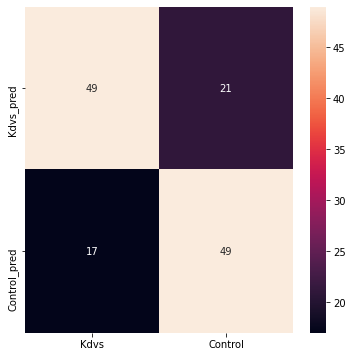

tn 52, fp 18, fn 19, tp 47
aroc: 0.8426406926406926 , spec: 0.7428571428571429, sens: 0.7121212121212122
trees: 10, norm: 1


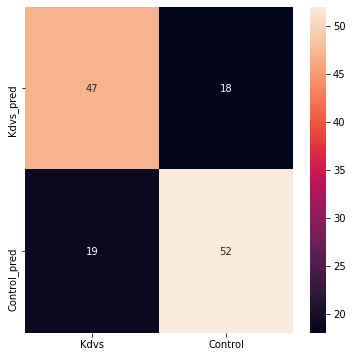

tn 52, fp 18, fn 17, tp 49
aroc: 0.8426406926406926 , spec: 0.7428571428571429, sens: 0.7424242424242424
trees: 10, norm: 1


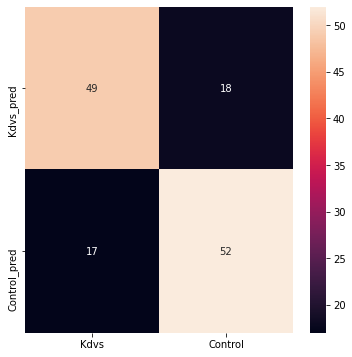

 67%|████████████████████████████▋              | 2/3 [11:18<04:37, 277.81s/it]

tn 57, fp 13, fn 17, tp 49
aroc: 0.8807359307359308 , spec: 0.8142857142857143, sens: 0.7424242424242424
trees: 20, norm: 0


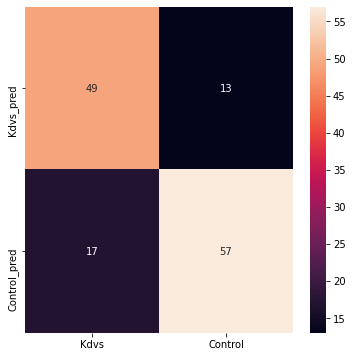

tn 53, fp 17, fn 12, tp 54
aroc: 0.8807359307359308 , spec: 0.7571428571428571, sens: 0.8181818181818182
trees: 20, norm: 0


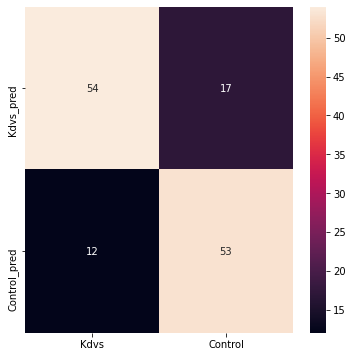

tn 53, fp 17, fn 13, tp 53
aroc: 0.8807359307359308 , spec: 0.7571428571428571, sens: 0.803030303030303
trees: 20, norm: 0


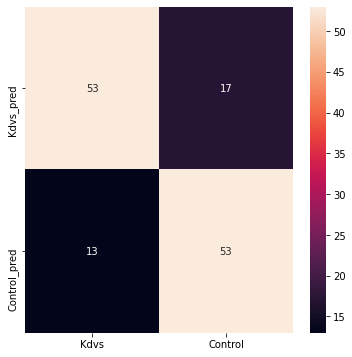

100%|███████████████████████████████████████████| 3/3 [30:45<00:00, 615.20s/it]

done running main file


In [42]:
def main():    
    
    today = date.today()
    start = time.time()
    
    data_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv" # representations\\"
    results_file = open("results/kdv-results-deepface-dlib-" + str(today)+".txt", "w")

    nr_feats = 300
    
    
    for data_combination in [2]: #[5, 6, 7]: # [1, 2, 3, 4]:
        
        results_file.write(get_header(data_combination, nr_feats))
        print(get_header(data_combination, nr_feats))
            
        age_ranges = [[1, 40]] #[[1, 3], [4, 16], [17, 40]] #, [1, 40]] 

        for [low_age, high_age] in age_ranges:
            
            method = "dlib"
            kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
            ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
            data_dlib, labels_dlib = read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir)

            method = "deepface"
            kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
            ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
            data_df, labels_df = read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir)


#             method = "openface"
#             kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
#             ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
#             data_openface, labels_openface = read_rep2(kdv_csv, ID_csv, low_age, high_age, data_dir)
            
#             method = "cfps"
#             kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
#             ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
#             data_cfps, labels_cfps = read_rep2(kdv_csv, ID_csv, low_age, high_age, data_dir)
            
            # data, labels depend on data_combination
            nr_comps, data, labels = concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, nr_feats)
            
            #nr_comps, data, labels = concatenate(data_openface, labels_openface, data_cfps, labels_cfps, data_combination, nr_feats)
        
#             print("Shape of the data is: {}".format(data.shape))
#             break

            if data_combination == 4:
                results_file.write("Nr of pca components used: {}\n\n".format(nr_comps))


            # plot representation
            # plot_pca_tsne(data, labels, low_age, high_age)

            results_file.write("CLASSIFIER RESULTS for kdv-control age group " + str(low_age) + "-" + str(high_age) + "\n")

            #k, knn_norm, knn_aroc, knn_spec, knn_sens = knn_classifier(data, labels)
            #results_file.write("knn classifier (k = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(k, knn_norm, knn_aroc, knn_spec, knn_sens))
            
            #kernel, svm_norm, svm_aroc, svm_spec, svm_sens = svm_classifier(data, labels)
            #results_file.write("svm classifier (k = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(kernel, svm_norm, svm_aroc, svm_spec, svm_sens))

            #n_trees_rf, rf_norm, rf_aroc, rf_spec, rf_sens = rf_classifier(data, labels)
            #results_file.write("Random Forest classifier (trees = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(n_trees_rf, rf_norm, rf_aroc, rf_spec, rf_sens))

            n_trees_gr, gr_norm, gr_aroc, gr_spec, gr_sens = gr_classifier(data, labels)
            results_file.write("Gradient Boost classifier (trees = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(n_trees_gr, gr_norm, gr_aroc, gr_spec, gr_sens))

            #n_trees_ada, ada_norm, ada_aroc, ada_spec, ada_sens = ada_classifier(data, labels)
            #results_file.write("Ada Boost classifier (trees = {}), normalize : {} \n    AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n".format(n_trees_ada, ada_norm, ada_aroc, ada_spec, ada_sens))

            results_file.write("\n")

    end = time.time()
    results_file.write("Running this whole file took {:.2f} hours".format((end-start)/3600.00))
    results_file.close()
    print("done running main file")
    
main()
    

### Method 7: VotingClassifier with GridSearch

https://www.kaggle.com/rmferg/soft-voting-classifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

import time
t0 = time.clock()

tree = DecisionTreeClassifier(random_state=1)
svm = SVC(probability=True, kernel='rbf')
knn = KNeighborsClassifier(p=2, metric='minkowski')
nb = GaussianNB()
eclf = VotingClassifier(estimators=[('tree', tree), ('svm', svm), ('knn', knn),('nb', nb)], voting='soft')

param_range10 = [.001, .01, 1, 10, 100]
param_range1 = list(range(3, 8))
param_grid = [{'svm__C':param_range10, 'svm__gamma':param_range10, 'tree__max_depth':param_range1, 
               'knn__n_neighbors':param_range1}]

gs = GridSearchCV(estimator=eclf, param_grid=param_grid, scoring='accuracy', cv=5)
gs = gs.fit(X_train_std, y_train)

print('Best accuracy score: %.3f \nBest parameters: %s' % (gs.best_score_, gs.best_params_))

clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
t1 = time.clock()
print('Running time: %.3f' % (t1-t0))

from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_std)
print('ROC AUC: %.3f \nAccuracy: %.3f \nConfusion Matrix:' % (roc_auc_score(y_true=y_test, y_score=y_pred),
                                         accuracy_score(y_true=y_test, y_pred=y_pred)))
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

### Method 7: Ensemble method

In [ ]:
def ensemble_classifiers(k, kernel, n_trees_rf, n_trees_gr, n_trees_ada, data, labels):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    svm = SVC(kernel=kernel, probability=True)
    random_forest = RandomForestClassifier(n_estimators=n_trees_rf) 
    gr_clf = GradientBoostingClassifier(n_estimators=n_trees_gr, learning_rate=1.0, max_depth=1, random_state=0)
    ada_clf = AdaBoostClassifier(n_estimators=n_trees_ada, random_state=0)
    nb = GaussianNB()

    classifiers = [('knn', knn), ('svm', svm),('gr_clf', gr_clf), ('random_forest', random_forest), ('nb', nb), ('ada_clf', ada_clf)]
    
    cv = int(len(labels)/2)

    classifier_combinations = []
    for L in range(1, len(classifiers)+1):
        for subset in itertools.combinations(classifiers, L):
            classifier_combinations.append(subset)
    
    best_ensemble_acc = 0
    best_classifier_com = None
    best_norm = -1
    best_vote = None

    for classifier_com in classifier_combinations:
    #for classifier_com in tqdm(classifier_combinations):
        
        for normalize in [0, 1, 2]:
            for vote_sort in ['soft', 'hard']:

                weights = np.ones(len(classifier_com)).tolist()
                ensemble_clf = VotingClassifier(estimators=classifier_com,
                                        voting=vote_sort,
                                        weights=weights)
                
                            
                mean_acc = cross_val_classifier(ensemble_clf, data, labels, normalize)
                
                clf_string = ""
                for clf in classifier_com:
                    clf_string  = clf_string + " " + clf[0]
                    
                print("Ensemble: {}".format(clf_string))
                print("With accuracy: {}".format(mean_acc))
                
                if mean_acc > best_ensemble_acc:
                    best_ensemble_acc = mean_acc
                    best_norm = normalize
                    best_vote = vote_sort
                    best_classifier_com = classifier_com
    
    return best_ensemble_acc, best_classifier_com, best_vote, best_norm